In [1]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
from process import get_data_CBMSTA, process_data
from train import train
warnings.filterwarnings("ignore")

In [2]:
dataset = ['Marmoset1_T479.h5ad']
num_classes_list = [3]

start_k_neighbor_num = [8]
rad_distance_num = [500 for _ in range(len(dataset))]
alpha_lists = [[0.8] for _ in range(len(dataset))]
beta_lists = [[1.0] for _ in range(len(dataset))]
mid_k_neighbor_lists = [[6] for i in range(len(dataset))]
mid_feature_dims = []

In [3]:
adata_list_post = []
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
data_name = 'CBMSTA'
method = 'GraphSTAR'
hidden_dim = 30   # 聚类的维度

lr = 0.001
reg = 1e-5
epochs = 1000
mode ='KNN'
save_adata_root = '../res/{}/{}/data'.format(method, data_name)
metric_list = {"ARI": [], "AMI": [], "NMI": []}
print("当前训练的数据集: {}".format(data_name))
for index, section_id in enumerate(dataset):
    print("切片:", section_id, " 聚类数量:", num_classes_list[index])
    adata = get_data_CBMSTA(section_id)
    adata = process_data(adata, data_name)
    adata.obs['Ground Truth'] = adata.obs['annotation']
    print("adata = ", adata)
    adata = train(adata, 
                  data_name=data_name, 
                  num_class=num_classes_list[index], 
                  mode=mode,
                  start_k_neighbor=start_k_neighbor_num[index], 
                  rad_distance=rad_distance_num[index], 
                  hidden_dim=hidden_dim,
                  mid_k_neighbor_list=mid_k_neighbor_lists[index],
                  alpha_list=alpha_lists[index],
                  beta_list=beta_lists[index], 
                  mid_feature_dims=mid_feature_dims,
                  lr=lr,
                  reg=reg,
                  epochs=epochs,
                  file_name=section_id,
                #   is_record=True,
                  device=device)
    adata_list_post.append(adata)
    metric = adata.uns['metric']
    metric_list['ARI'].append(metric['ARI'])
    metric_list["AMI"].append(metric['AMI'])
    metric_list["NMI"].append(metric['NMI'])
    print('slice = %s last metric:, ARI = %.2f, AMI = %.2f, NMI = %.2f' % (section_id, metric["ARI"], metric["AMI"], metric["NMI"]))

当前训练的数据集: CBMSTA
切片: Marmoset1_T479.h5ad  聚类数量: 3
adata =  AnnData object with n_obs × n_vars = 4840 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'region', 'coor_x', 'coor_y', 'raw_x', 'raw_y', 'distance', 'area', 'Astrocyte', 'Bergmann', 'Choroid', 'Endothelial_stalk', 'Ependymal', 'Fibroblast', 'Golgi', 'Granule', 'MLI1', 'MLI2', 'Microglia', 'ODC', 'OPC', 'Purkinje', 'UBC', 'cluster', 'annotation', 'Ground Truth'
    var: 'geneID', 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'annotation_colors', 'hvg', 'log1p'
    obsm: 'spatial'
空间位置的平均邻居数: tensor(8.7017)
空间位置的平均邻居数: tensor(8.7017)
in_features = 3000, mid_feature1 = NULL, cluster_features = 30
begin training


100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
slice = Marmoset1_T479.h5ad last metric:, ARI = 0.74, AMI = 0.69, NMI = 0.69


In [4]:
for index, section_id in enumerate(dataset):
    # 保存到文件
    # 如果save_adata_root路径不存在
    if not os.path.exists(save_adata_root):
        os.makedirs(save_adata_root)
    adata = adata_list_post[index]
    full_path_save_data = os.path.join(save_adata_root, 'slice_{} adata.h5ad'.format(section_id))
    adata.write_h5ad(full_path_save_data)

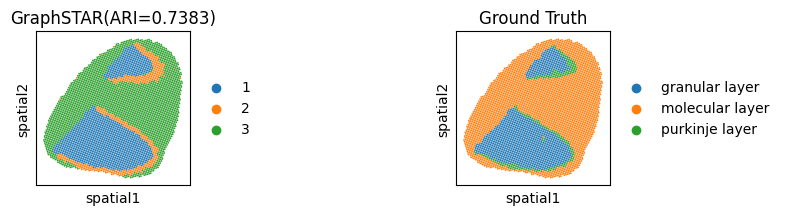

In [5]:
import scanpy as sc
for index, section_id in enumerate(dataset):
    adata = adata_list_post[index]
    plt.rcParams["figure.figsize"] = (4, 2)
    sc.pl.spatial(adata, color=["predict", "Ground Truth"],
                title=['GraphSTAR(ARI={:.4f})'.format(metric_list['ARI'][index]), "Ground Truth"],
                save='slice_{}_spatial_plot.png'.format(section_id), spot_size=1.0)